# Run CFE Simulation in the Cloud

**Authors**

- Tony Castronova: acastronova@cuahsi.org
- Irene Garousi-Nejad: igarousi@cuahsi.org
- Scott Black: sblack@cuahsi.org

**Last Updated:** 05.17.2023

**Description**

This notebook demonstrates how to build and execute scientific workflows in the cloud using cyberinfrastructure developed as part of the "HydroShare Modernization" CIROH research project. The goal is do illustrate how the general-purpose cloud analysis workflows that have been developed to support common data archival operations, can also be leveraged for scientific computing. This notebook describes the process for using the outcomes of the aforementioned CIROH project, however these capabilities are still under active development are not ready for wide-spread public use.


**Data Availability**

This notebook requires the NextGen Hydrofabric that is hosted on http://lynker-spatial.com. These data are subdivided into a series of GeoPackage files grouped relative to the portion of the USA in which they are located.. Data can be accessed in a variety of ways, the simplest being a direct download:

```
wget https://lynker-spatial.s3-us-west-2.amazonaws.com/hydrofabric/v20.1/gpkg/nextgen_16.gpkg
```

**Computational Availability**

This notebook leverages advanced cyberinfrastructure that is currently under active development. It has been made available to attendees that the 2024 CIROH User and Developer Conference, however it is not currently available to the general public. Access to this system may be terminated without notice.


**Software Requirements**

- fiona==1.9.6  
- fsspec==2024.5.0  
- geopandas==0.14.4  
- ipyleaflet==0.19.1  
- matplotlib==3.9.0  
- numpy==1.26.4  
- pandas==2.2.2  
- pyproj==3.6.1  
- s3fs==2024.5.0  
- shapely==2.0.4  
- sidecar==0.7.0  
- swagger-client @ git+https://github.com/CUAHSI/argo-workflow-python-client.git@954441c4dc47a05e80bd5eb1186f3723a4863d8d  
- tabulate==0.9.0  
- xarray==2024.5.0  


In [ ]:
!pip install -r requirements.txt

In [ ]:
import fiona
import fsspec
import utils
import geopandas
import ipyleaflet
from datetime import datetime
from helpers import ArgoAPI, SideCarMap

In order to interact with the CUAHSI Argo service, we need to set our `ARGO_TOKEN`. This is obtained directly from the [Argo interface](https://workflows.argo.cuahsi.io/userinfo).

In [ ]:
ARGO_TOKEN='Bearer v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.P8Y5hNp3DdJVORstWSFy8q6Xl_3iF97xVxAX0fKpQRNXHECQHFmXQ_RdPf-K3DLv81G43FqnPFbF-gvYjIM_D109eVR4sTpo73NYePUGPnSNi9Aj2e1CD2rSbmrbgRWAQ7V0oNvR5xNkeHgBSFCfA52aGW70X6jkDsipgB6AUPPpRfU-6xNaeNVXSdOsTsTTnUeIr-31I4GMkC-H0NNfMrUy4L_X03Hh2qAfEhmZrEmamC0nb82_0Xp3ILaA4Dljz0Up18dswe228Xrnzz-v6ZAuLL0gBjgSPRrh01VIkHn7fptaj9PyCKgDu7yHYEGeLhhHFOovgRVcq9jycibfAQ.Vl2wN2O06KseSAcd.YzZvIP9SOWaessySlymoVCxhtQvU9uLUaBo6uLON44ZPPSNaVvY0HneyALYaiThHLw-r-wQpNQm89QRfCiHhiv6WxbdShIXgiWoY2GfD_r5LnNgEyJtmypYJccIN7s-jrc_gNlmwiH7lFmEckBm1R7RAK_6Pp5RwX9LklzGwZTpjbpbN0CngawhF53LJU4O31yZI-guRpqe-jNW-tOkFGsoUio1cshnx-SmOa3POUUkbUgd7B9d6q-JcZpaylet21rZy3QAEGB-U9rn0u605t2Cidcntz8DrXQ.7Qg-QPVK97vcggisR4RaZQ'

Create an instance of the `ArgoAPI` class. This will help keep our notebook clean by wrapping Argo REST API function calls.

In [ ]:
# create an instance of ArgoAPI using our ARGO_TOKEN
argo = ArgoAPI(ARGO_TOKEN)

List the workflows that are available for us to use. Each of the workflows listed below are actually *templates* that can be modified with custom input and output parameters. Each defines a single task or a set of tasks that will be performed in a specific order. 

In [ ]:
argo.list_workflows()

We can learn more about these workflows by looking at their metadata. The `helper` library contains some functions to display workflow metadata in a clear manner. It's important that we understand what these are so that we can successfully invoke a workflow.

In [ ]:
# display the metadata for the workflow
argo.describe('run-cfe-complete-new-path')

To run this workflow, we need to provide values for each of the input parameters listed above. While some of these are obvious others are more nondescript, for example `wb-id` and `vpu-id`. These are attributes obtained from the NextGen Hydrofabric. To simplify the process of acquiring these, we'll use a map interface provided in the `helpers.py` file.

The data that we'll be using this notebook are located inside Vector Processing Unit 16. This area of the Hydrofabric covers the Great Basin. See the [NextGen Hydrofabric](https://mikejohnson51.github.io/hyAggregate/) help pages for more information regarding these data. A geopackage file may consist of many layers. Use `Fiona` to view the vector layers that are included within the `nextgen_16` geopackage.


In [ ]:
# list the layers include in the nextgen geopackage for VPU 16.
fiona.listlayers('nextgen_16.gpkg')

Our workflow will require the ID of the outlet catchment, so let's load the 'divides' layer. This layer contains over 30,000 features so we will not attempt to display it in the notebook. For reference, these data cover the following area:

<div>
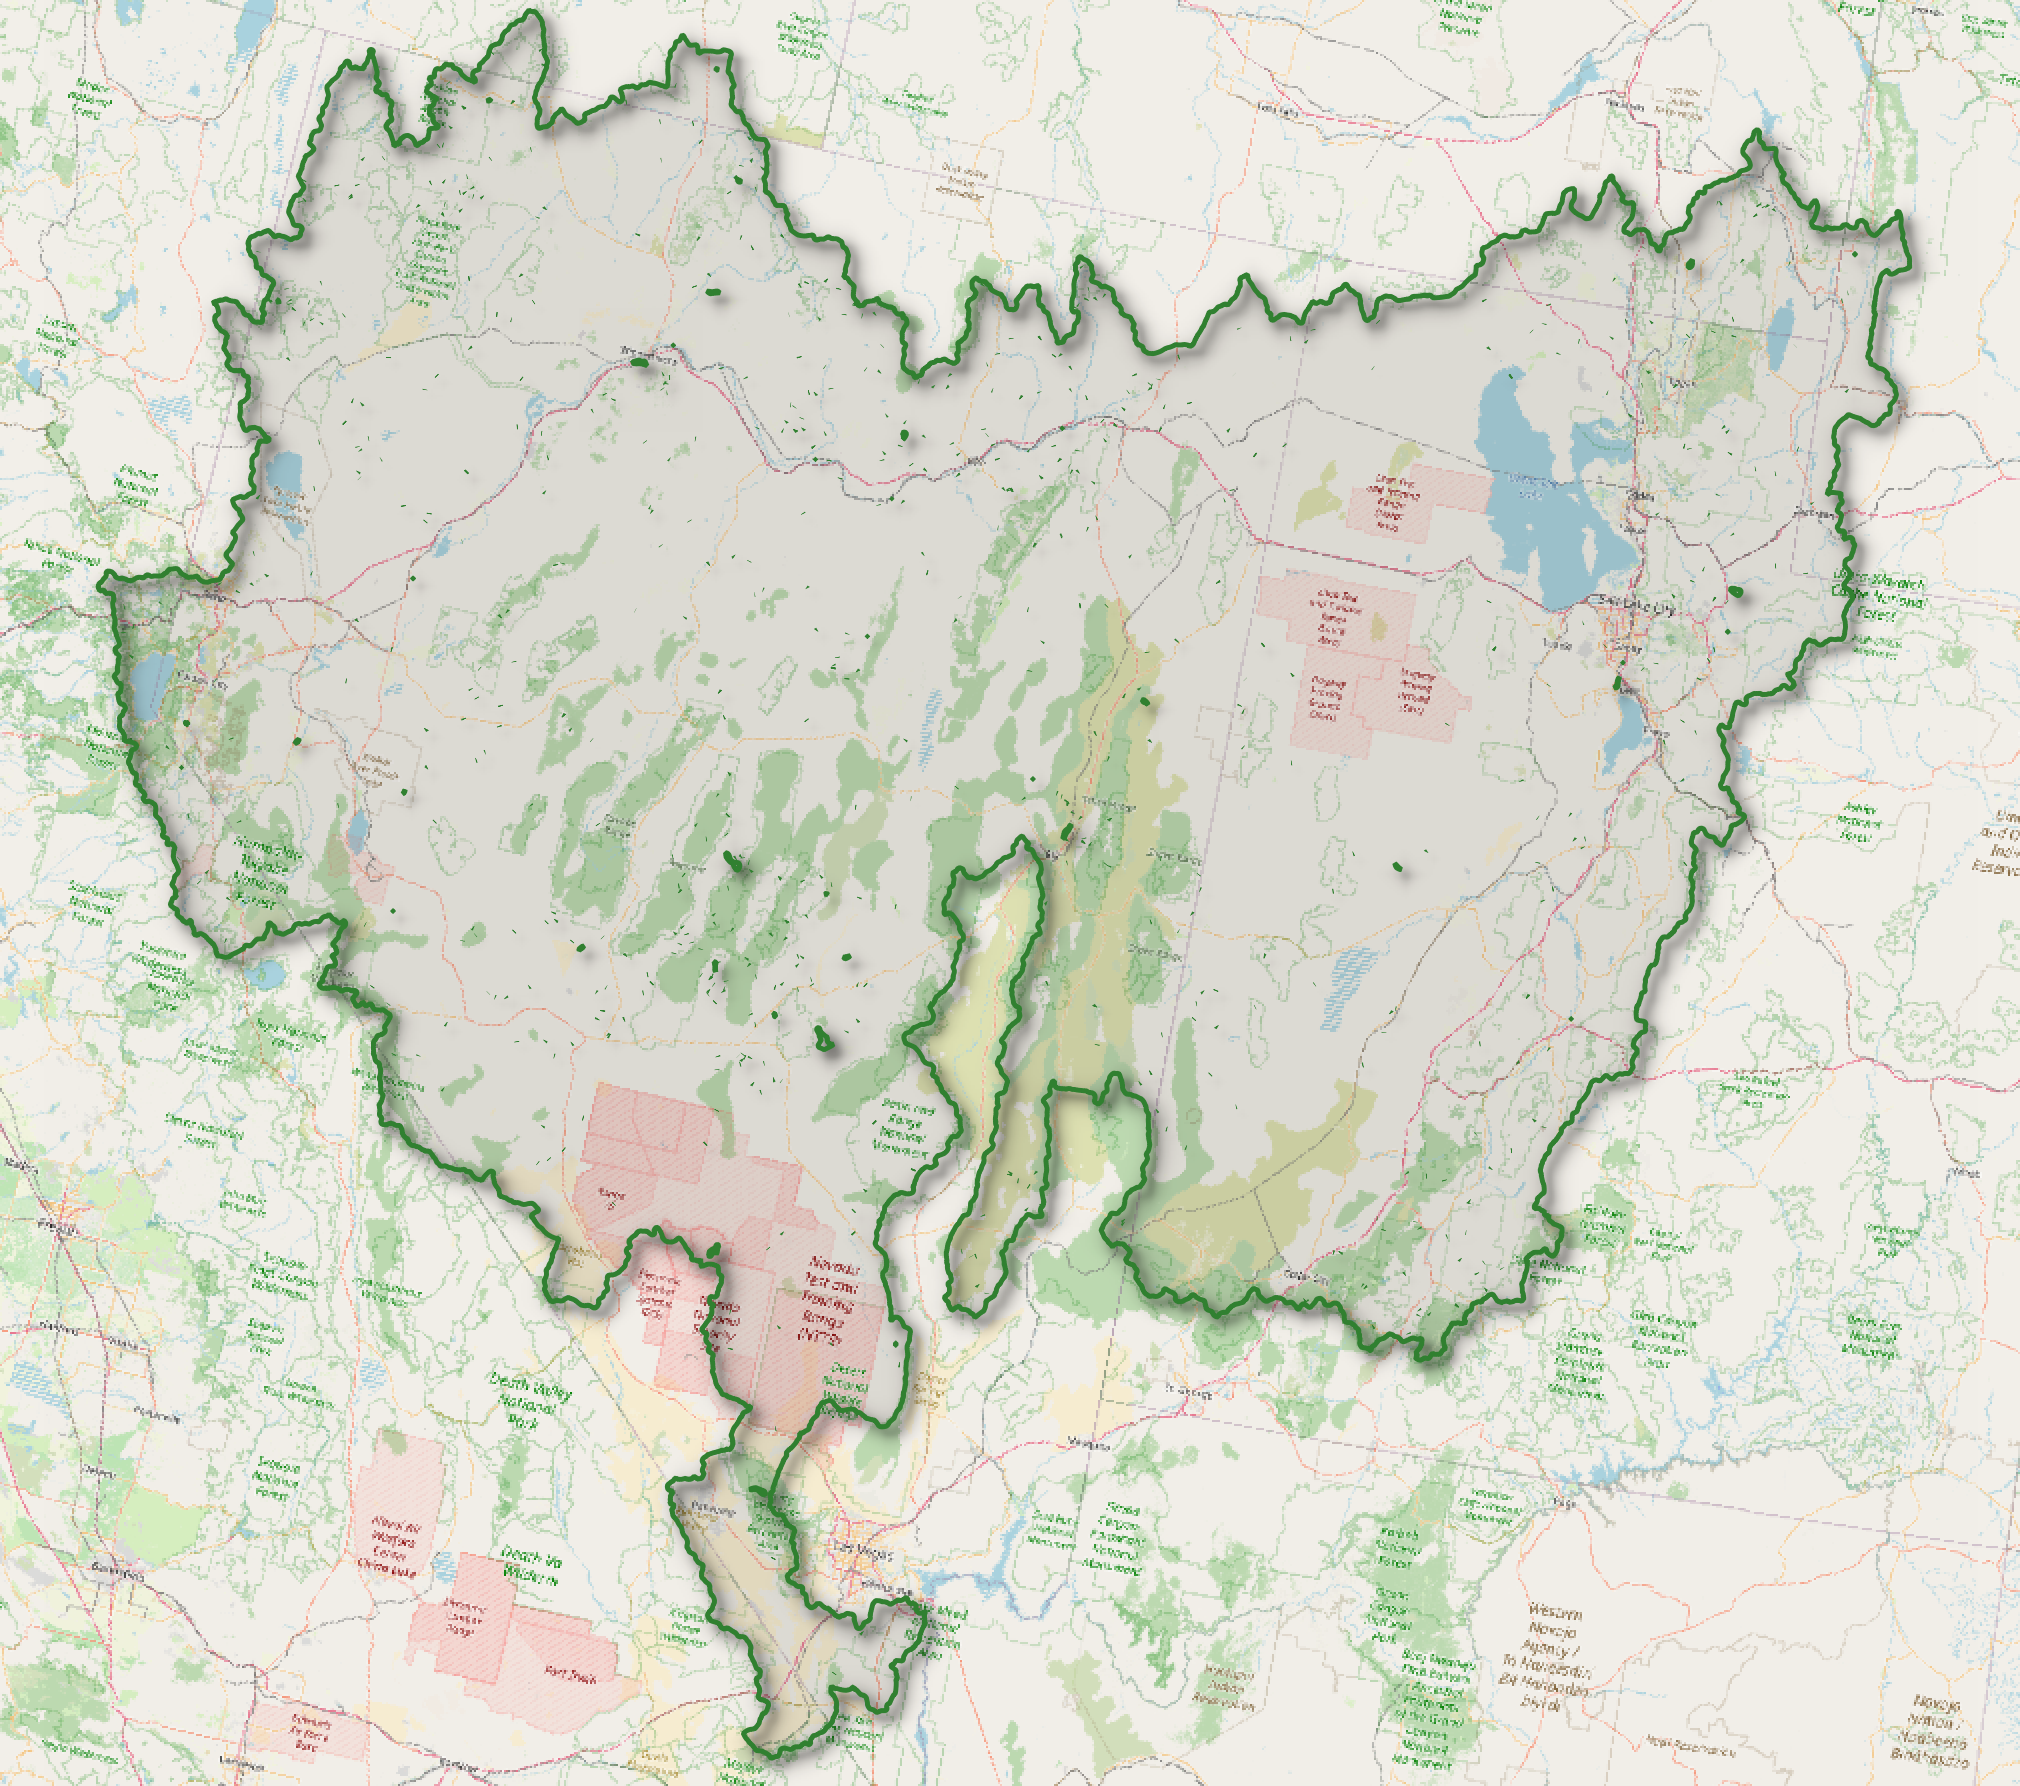
</div>



Load these data into `Geopandas` and convert into the coordinate reference we will be using in out leaflet map (EPSG: 4326).

In [ ]:
gdf = geopandas.read_file('nextgen_16.gpkg', layer='divides')
gdf = gdf.to_crs(epsg='4326')

Launch an interactive map interface for us to select our area of interest. We'll pass the `divides` geometries that were loaded above so we can query them when the map is clicked and retrieve their metadata. 

In [ ]:
m = SideCarMap(gdf=gdf)
m.display_map()

This map contains USGS river gauges and NHD+ reach geometries to help us select our area of interest. After selecting our outlet catchment we can access it's metadata in the notebook using the `m.selected()` command. We're interested in the `id` attribute of this feature. It should look something like: `wb-2853613`.

In [ ]:
selected_catchment = m.selected()
selected_catchment

Now that we've selected our feature-of-interest, let's prepare the remaining input parameters needed for workflow.

In [ ]:
wb_id         = selected_catchment.id  # the id of the selected catchment on the map.
vpu_id        = 16                     # the VPU ID of the data we loaded, i.e. 16.
output_bucket = 'scratch'              # this is a bucket specifically created for this workshop.
start_date    = '2018-01-01'           # the start date of our simulation.
end_date      = '2018-12-01'           # the end date of our simulation.

# define input parameters for the job
parameters = {'wb-id'        : wb_id,
              'vpu-id'       : vpu_id,
              'output-bucket': output_bucket,
              'start-date'   : start_date,
              'end-date'     : end_date}

parameters

## Submit the workflow!

The output of this function is a unique identifier for the job. We'll save this to the `job_name` variable so that we can use it later to interact with the job.

In [ ]:
job_name = argo.submit_workflow('run-cfe-complete-new-path', parameters)
job_name

Get the status of our running job.

In [ ]:
w = argo.workflow_api_instance.workflow_service_get_workflow(argo.namespace, job_name)

def get_node(name):
    return w.status.nodes[name]
    
def collect_nodes(name, d):
    
    node = get_node(name)
    children = node.children
    if node.display_name[-3:] != '(0)':    
        d[node.display_name] = node.id 
    if children is not None:
        for child in children:
            collect_nodes(child, d)
    return d

def print_workflow_status(job_name):
    job_ids = collect_nodes(job_name, {})
    still_running = True
    statuses = []
    for display_name, name in job_ids.items():
        node = get_node(name)
        statuses.append(node.phase)
        if node.phase == 'Succeeded':
            st = datetime.strptime(node.started_at, '%Y-%m-%dT%H:%M:%SZ')
            et = datetime.strptime(node.finished_at, '%Y-%m-%dT%H:%M:%SZ')
            print(f'{display_name}: {node.phase} -> {(et-st).total_seconds():.2f} seconds')
        else:
            print(f'{display_name}: {node.phase}')
    return statuses

In [ ]:
stats = print_workflow_status(job_name)

To preview the output data that our job created, we need to first construct the url to our output data. Our output path use our hydroshare username so that we can easily find it.

In [ ]:
hydroshare_username = 'tonycastronova'
url = f's3://{output_bucket}/{hydroshare_username}/{wb_id}/{job_name}'

print(f'Browse the output files at:')
print(f'https://console.minio.cuahsi.io/browser/{output_bucket}/{hydroshare_username}/{wb_id}/{job_name}/')

In [ ]:
from pathlib import Path

# connect to the CUAHSI MinIO server that is hosting our data
s3 = fsspec.filesystem("s3",
                       anon=True,
                       client_kwargs={'endpoint_url':'https://api.minio.cuahsi.io'},
                       use_listings_cache=False,
                      )

def pretty_list(url, indent_count=0):
    items = s3.listdir(url)
    for item in items:
        if item['type'] == 'directory':
            indent = ' '*indent_count
            name = Path(item['name']).name
            print(f'{indent}+ {name}')
            next_indent_count = indent_count + 1
            pretty_list(item['Key'], next_indent_count)
        else:
            if item['type'] == 'file':
                indent = ' '*indent_count
                name = Path(item['name']).name
                print(f'{indent}- {name}')


In [ ]:
pretty_list(url)

## Preview HydroFabric on the Map

The subsetted NextGen HydroFabric data is located in the `/domain` directory. Let's load the Geopackage file that contains the hydrofabric geometries that were used in our simulation.

In [ ]:
gpkg_url=f'{url}/domain/{selected_catchment.id}_upstream_subset.gpkg'
gpkg_url

This Geopackage file contains several layers. Lets load the catchment divides and nexus points and convert them into the coordinate reference system used in the map interface.

In [ ]:
subset_divides = geopandas.read_file(s3.open(gpkg_url), layer='divides')
subset_divides = subset_divides.to_crs(epsg='4326')

subset_nexus = geopandas.read_file(s3.open(gpkg_url), layer='nexus')
subset_nexus = subset_nexus.to_crs(epsg='4326')

Load these geometries on the map.

In [ ]:
# add catchment divides to the map
for idx, row in subset_divides.iterrows():

    wlayer = ipyleaflet.WKTLayer(
        wkt_string=row.geometry.wkt,
            style={'color': 'red', 'opacity':1, 'weight':2.,})
    m.map.add(wlayer)

# add nexus points to the map
for idx, row in subset_nexus.iterrows():

    wlayer = ipyleaflet.WKTLayer(
        wkt_string=row.geometry.wkt,
            style={'color': 'black', 'opacity':1, 'weight':2.,})
    m.map.add(wlayer)


## Preview Simulation Results

The results and forcing data are locating the directories `/results` and `/forcing`, respectively.

In [ ]:
results_path = f'{url}/results'
forcing_path = f'{url}/forcing'
print(f'forcing_path: {forcing_path}\nresults_path: {results_path}')

Let's load the data associated with our most downstream catchment. First we need to identify the divide and nexus identifier for this catchment, then load the simulated results using Xarray. The latter is done with a utility library to keep our notebook clean.

In [ ]:
# get the catchment and nexus ids associated with the most downstream catchment, i.e. the one that was used as input to our workflow.
outlet_cat_id = selected_catchment.divide_id
outlet_nex_id = selected_catchment.toid
print(f'cat-id: {outlet_cat_id}, nex-id: {outlet_nex_id}')

In [ ]:
# get the catchment output results
cat_csv_files = s3.glob(f'{results_path}/cat*.csv')
nex_csv_files = s3.glob(f'{results_path}/nex*.csv')
forcing_csv_files = s3.glob(f'{forcing_path}/cat*.csv')

xr_nex = utils.nex_csv2xr(s3, nex_csv_files)
xr_cat = utils.cat_csv2xr(s3, cat_csv_files)
xr_forcing = utils.forcing_csv2xr(s3, forcing_csv_files)


Create a plot of simulated streamflow and input preciptation.

In [ ]:
utils.plot_precip_and_flow(outlet_cat_id, outlet_nex_id, xr_cat, xr_nex, xr_forcing)

Let's output the paths to our data so we can reference these in the future. This is particularly useful for when we want to make modifications to our simulation configuration.

In [ ]:
print(f'bucket_name="{output_bucket}"')
print(f'data_path="{hydroshare_username}/{wb_id}/{job_name}/"')
print(f'MinIO Path = https://console.minio.cuahsi.io/browser/{output_bucket}/{hydroshare_username}/{wb_id}/{job_name}/')